# Partie 1 – Visualisation des données et aide à la définition des seuils conditionnels

## Exctracting datas

In [312]:
# import
import sqlite3
import settings as s
import os
import pandas as pd
import numpy as n
import matplotlib.pyplot as plt
import seaborn as sns

In [340]:
# Extracting all datas
def get_constraints_from_db(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM ClassificationConstraints LIMIT 1")
    row = cursor.fetchone()
    conn.close()

    if not row:
        raise ValueError("Aucune contrainte trouvée dans la table.")

    columns = [
        "id", "min_size", "max_size", "min_height", "max_height", "min_width", "max_width",
        "min_avg_r", "max_avg_r", "min_avg_g", "max_avg_g", "min_avg_b", "max_avg_b",
        "min_contrast", "max_contrast", "min_edges", "max_edges"
    ]
    return dict(zip(columns, row))

def get_image_from_db(db_path, with_label=False):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    query = "SELECT * FROM Image"

    if (with_label):
        query="SELECT * FROM Image WHERE File_path LIKE 'train/with_label/%' "
    cursor.execute(query)
    rows = cursor.fetchall()
    conn.close()

    rows = n.transpose(rows)

    columns = [
        "id_image", "File_name", "File_path", "Size", "Height", "Width",
        "Date_taken", "Avg_R", "Avg_G", "Avg_B",
        "Contrast_level", "RGB_Histogram", "Luminance_Histogram", "Edges","Status"
    ]
    return dict(zip(columns, rows))

db_path = os.path.join(s.BASE_DIR, "db.sqlite3")

image_data = get_image_from_db(db_path, True)

constraints = get_constraints_from_db(db_path)


In [341]:
image_data = pd.DataFrame(image_data)
image_data.head(5)

,id_image,File_name,File_path,Size,Height,Width,Date_taken,Avg_R,Avg_G,Avg_B,Contrast_level,RGB_Histogram,Luminance_Histogram,Edges,Status
0,661,WhatsApp Image 2020-05-09 at 2.03.38 PM (1).webp,train/with_label/clean/WhatsApp Image 2020-05-...,67.45,147,123,2025-06-23,54.614402,53.507328,47.586693,34.922488,"{""red"": [57.0, 159.0, 113.0, 63.0, 42.0, 67.0,...","[30.0, 105.0, 92.0, 127.0, 64.0, 82.0, 44.0, 4...",1747,0
1,662,00543_02.webp,train/with_label/clean/00543_02.webp,68.59,181,202,2025-05-28,70.781194,87.713391,76.828647,30.181239,"{""red"": [10.0, 5.0, 8.0, 4.0, 5.0, 8.0, 8.0, 5...","[0.0, 0.0, 1.0, 3.0, 1.0, 1.0, 1.0, 6.0, 6.0, ...",3416,0
2,663,WhatsApp Image 2020-05-09 at 2.03.38 PM (3).webp,train/with_label/clean/WhatsApp Image 2020-05-...,51.21,191,191,2025-06-03,140.876045,138.107015,111.220471,42.040069,"{""red"": [19.0, 4.0, 7.0, 18.0, 15.0, 23.0, 29....","[8.0, 27.0, 17.0, 25.0, 36.0, 37.0, 25.0, 68.0...",5626,0
3,664,WhatsApp Image 2020-05-09 at 2.03.37 PM (6).webp,train/with_label/clean/WhatsApp Image 2020-05-...,23.9,308,327,2025-06-13,137.124499,140.567239,122.971683,37.2775,"{""red"": [0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 3.0, 2....","[0.0, 0.0, 3.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, ...",6414,0
4,665,00547_06.webp,train/with_label/clean/00547_06.webp,71.62,101,76,2025-06-04,100.285826,118.591193,108.447108,48.112718,"{""red"": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1801,0


In [315]:
constraints

{'id': 1,
 'min_size': 0.0,
 'max_size': 5000.0,
 'min_height': 0,
 'max_height': 5000,
 'min_width': 0,
 'max_width': 5000,
 'min_avg_r': 0.0,
 'max_avg_r': 255.0,
 'min_avg_g': 0.0,
 'max_avg_g': 255.0,
 'min_avg_b': 0.0,
 'max_avg_b': 255.0,
 'min_contrast': 0.0,
 'max_contrast': 1.0,
 'min_edges': 0,
 'max_edges': 10000}

In [342]:
import json
import pandas as pd

# Fonction qui prend la chaîne JSON et renvoie les indices max
def extract_max_indices(hist_str):
    if pd.isna(hist_str):
        return pd.Series([None, None, None], index=["Max_Red_Index", "Max_Green_Index", "Max_Blue_Index"])
    
    hist = json.loads(hist_str)
    r = max(enumerate(hist["red"]), key=lambda x: x[1])[0]
    g = max(enumerate(hist["green"]), key=lambda x: x[1])[0]
    b = max(enumerate(hist["blue"]), key=lambda x: x[1])[0]
    return pd.Series([r, g, b], index=["Max_Red_Index", "Max_Green_Index", "Max_Blue_Index"])

# Application de la fonction sur toute la colonne
image_data[["Max_Red_Index", "Max_Green_Index", "Max_Blue_Index"]] = image_data["RGB_Histogram"].apply(extract_max_indices)


In [343]:
# Convertir les colonnes en float avant la somme pour éviter la concaténation de chaînes
image_data["sum_rgb"] = image_data[["Avg_R", "Avg_G", "Avg_B"]].astype(float).sum(axis=1)
image_data.drop(columns=["id_image", "File_name", "File_path", "Date_taken", "RGB_Histogram", "Luminance_Histogram", "Height", "Width"], inplace=True)

In [344]:
image_data = image_data.astype(float)

In [345]:
image_empty = image_data[image_data["Status"]==0]
image_full = image_data[image_data["Status"]==1]

In [346]:
image_empty

,Size,Avg_R,Avg_G,Avg_B,Contrast_level,Edges,Status,Max_Red_Index,Max_Green_Index,Max_Blue_Index,sum_rgb
0,67.45,54.614402,53.507328,47.586693,34.922488,1747.0,0.0,41.0,47.0,34.0,155.708423
1,68.59,70.781194,87.713391,76.828647,30.181239,3416.0,0.0,53.0,70.0,68.0,235.323232
2,51.21,140.876045,138.107015,111.220471,42.040069,5626.0,0.0,139.0,151.0,116.0,390.203531
3,23.90,137.124499,140.567239,122.971683,37.277500,6414.0,0.0,135.0,148.0,120.0,400.663420
4,71.62,100.285826,118.591193,108.447108,48.112718,1801.0,0.0,66.0,88.0,71.0,327.324127
5,82.88,97.119669,93.185190,79.703868,61.719640,2272.0,0.0,49.0,45.0,41.0,270.008727
6,69.07,87.984903,96.713595,82.804098,27.533588,3169.0,0.0,116.0,118.0,116.0,267.502596
7,28.85,79.909373,98.675720,73.190966,36.983625,2500.0,0.0,66.0,90.0,58.0,251.776059
8,57.77,118.747299,122.425302,116.477254,40.878619,10941.0,0.0,76.0,84.0,73.0,357.649855
9,48.39,98.923307,97.403280,80.507073,44.664811,7258.0,0.0,64.0,68.0,42.0,276.833661


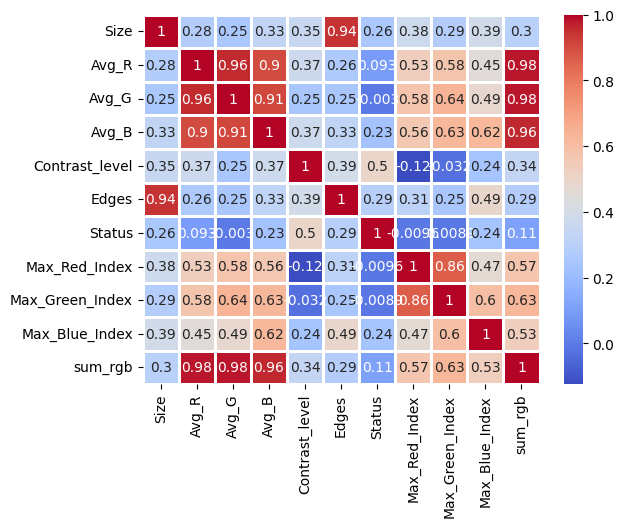

In [347]:
corr = image_data.corr ()
sns.heatmap(corr, cmap='coolwarm', annot = True, linewidth =0.9)
plt.show()

**Analyse :** On va utiliser les variables avec une correlation superieure à 0.2 

## Rules Tuning

In [348]:
def fit_polynomial(df, x_col, y_col, degree=2):
    """
    Ajuste une régression polynomiale sur tout le DataFrame et renvoie une fonction polynomiale utilisable.
    
    Args:
        df (pd.DataFrame): Tableau avec les données.
        x_col (str): Nom de la colonne x.
        y_col (str): Nom de la colonne y.
        degree (int): Degré du polynôme.
        
    Returns:
        np.poly1d: La fonction polynomiale.
    """
    coefs = n.polyfit(df[x_col], df[y_col], deg=degree)
    poly_fn = n.poly1d(coefs)
    return poly_fn

image_empty["x"] = n.arange(len(image_empty["Edges"]))
image_full["x"] = n.arange(len(image_full["Edges"]))



/var/folders/s8/0f2wgqdd6953wlwbgn3cr_480000gn/T/ipykernel_90959/1616423379.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_empty["x"] = n.arange(len(image_empty["Edges"]))
/var/folders/s8/0f2wgqdd6953wlwbgn3cr_480000gn/T/ipykernel_90959/1616423379.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_full["x"] = n.arange(len(image_full["Edges"]))


### Edges

In [349]:
s = {
    'count': image_empty["Edges"].count(),
    'min': image_empty["Edges"].min(),
    'max': image_empty["Edges"].max(),
    'median': image_empty["Edges"].median(),
    'mean': image_empty["Edges"].mean(),
    'std': image_empty["Edges"].std()
}

print("Edges - Empty")
for key, value in s.items():
    print(f"{key.capitalize():<8}: {value}")

s = {
    'count': image_full["Edges"].count(),
    'min': image_full["Edges"].min(),
    'max': image_full["Edges"].max(),
    'median': image_full["Edges"].median(),
    'mean': image_full["Edges"].mean(),
    'std': image_full["Edges"].std()
}

print("\nEdges - Full")
for key, value in s.items():
    print(f"{key.capitalize():<8}: {value}")


Edges - Empty
Count   : 20
Min     : 759.0
Max     : 48779.0
Median  : 3521.5
Mean    : 7549.9
Std     : 10957.067178189995

Edges - Full
Count   : 20
Min     : 990.0
Max     : 983423.0
Median  : 15724.5
Mean    : 102565.65
Std     : 223361.91124396137


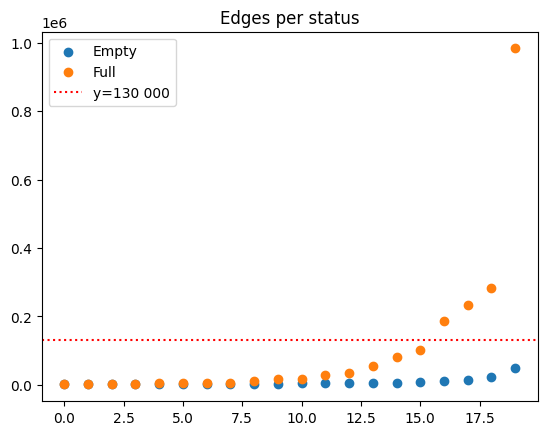

In [350]:
plt.scatter(image_empty["x"], sorted(image_empty["Edges"]), label="Empty")
plt.scatter(image_full["x"], sorted(image_full["Edges"]), label="Full")
plt.axhline(y=130000, color='red', linestyle=':', label='y=130 000')
plt.title("Edges per status")
plt.legend()
plt.show()

L'utilisation de la regréssion polynomiale ne sera malheureusement pas utilisée sous la contrainte du cahier des charges.

### Size

In [326]:
s = {
    'count': image_full["Size"].count(),
    'min': image_full["Size"].min(),
    'max': image_full["Size"].max(),
    'median': image_full["Size"].median(),
    'mean': image_full["Size"].mean(),
    'std': image_full["Size"].std()
}
print("Size - Full")
for key, value in s.items():
    print(f"{key.capitalize():<8}: {value}")

s = {
    'count': image_empty["Size"].count(),
    'min': image_empty["Size"].min(),
    'max': image_empty["Size"].max(),
    'median': image_empty["Size"].median(),
    'mean': image_empty["Size"].mean(),
    'std': image_empty["Size"].std()
}
print("Size - Empty")
for key, value in s.items():
    print(f"{key.capitalize():<8}: {value}")


Size - Full
Count   : 20
Min     : 20.95
Max     : 6458.14
Median  : 68.98
Mean    : 730.794
Std     : 1524.2758680812135
Size - Empty
Count   : 20
Min     : 23.9
Max     : 1821.85
Median  : 63.870000000000005
Mean    : 152.734
Std     : 394.35618312970774


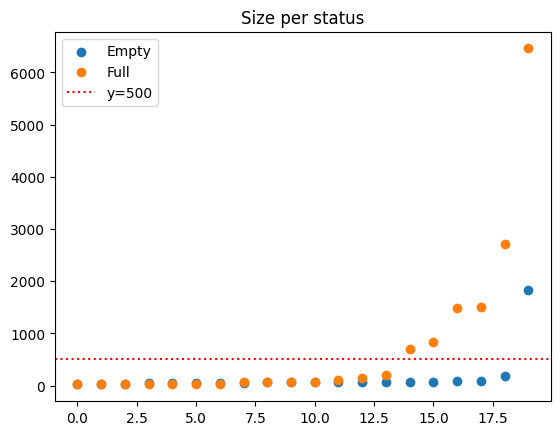

In [327]:
# Conversion des colonnes "Edges" en float pour le tri et le tracé
size_empty = image_empty["Size"].astype(float)
size_full = image_full["Size"].astype(float)

plt.scatter(n.arange(len(size_empty)), sorted(size_empty), label="Empty")
plt.scatter(n.arange(len(size_full)), sorted(size_full), label="Full")
plt.axhline(y=500, color='red', linestyle=':', label='y=500')
plt.title("Size per status")
plt.legend()
plt.show()

### Avg_R / Avg_G

In [328]:
s = {
    'count': image_full["Avg_R"].count(),
    'min': image_full["Avg_R"].min(),
    'max': image_full["Avg_R"].max(),
    'median': image_full["Avg_R"].median(),
    'mean': image_full["Avg_R"].mean(),
    'std': image_full["Avg_R"].std()
}
print("Avg_R - Full")
for key, value in s.items():
    print(f"{key.capitalize():<8}: {value}")

s = {
    'count': image_empty["Avg_R"].count(),
    'min': image_empty["Avg_R"].min(),
    'max': image_empty["Avg_R"].max(),
    'median': image_empty["Avg_R"].median(),
    'mean': image_empty["Avg_R"].mean(),
    'std': image_empty["Avg_R"].std()
}
print("Avg_R - Empty")
for key, value in s.items():
    print(f"{key.capitalize():<8}: {value}")


Avg_R - Full
Count   : 20
Min     : 57.141301495670426
Max     : 121.6716280796926
Median  : 105.41157825543922
Mean    : 98.54977437613175
Std     : 20.277218955110566
Avg_R - Empty
Count   : 20
Min     : 54.6144018583043
Max     : 140.87604506455415
Median  : 92.88421862897604
Mean    : 94.56116536694375
Std     : 23.514918523693765


In [329]:
s = {
    'count': image_full["Avg_G"].count(),
    'min': image_full["Avg_G"].min(),
    'max': image_full["Avg_G"].max(),
    'median': image_full["Avg_G"].median(),
    'mean': image_full["Avg_G"].mean(),
    'std': image_full["Avg_G"].std()
}
print("Avg_G - Full")
for key, value in s.items():
    print(f"{key.capitalize():<8}: {value}")

s = {
    'count': image_empty["Avg_G"].count(),
    'min': image_empty["Avg_G"].min(),
    'max': image_empty["Avg_G"].max(),
    'median': image_empty["Avg_G"].median(),
    'mean': image_empty["Avg_G"].mean(),
    'std': image_empty["Avg_G"].std()
}
print("Avg_G - Empty")
for key, value in s.items():
    print(f"{key.capitalize():<8}: {value}")


Avg_G - Full
Count   : 20
Min     : 63.34233539094651
Max     : 122.3417450851703
Median  : 107.46612307710103
Mean    : 100.49921986586392
Std     : 19.48147711860528
Avg_G - Empty
Count   : 20
Min     : 53.50732813450583
Max     : 140.56723857182573
Median  : 97.05843791258835
Mean    : 100.61875112588453
Std     : 21.415465922994905


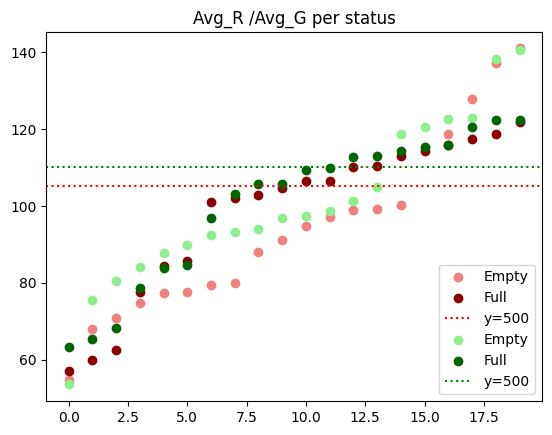

In [ ]:
avg_r_empty = image_empty["Avg_R"].astype(float)
avg_r_full = image_full["Avg_R"].astype(float)
avg_g_empty = image_empty["Avg_G"].astype(float)
avg_g_full = image_full["Avg_G"].astype(float)
plt.scatter(n.arange(len(avg_r_empty)), sorted(avg_r_empty), label="Empty", color='lightcoral')
plt.scatter(n.arange(len(avg_r_full)), sorted(avg_r_full), label="Full", color='darkred')
plt.axhline(y=105, color='red', linestyle=':', label='y=105')
plt.scatter(n.arange(len(avg_g_empty)), sorted(avg_g_empty), label="Empty", color='lightgreen')
plt.scatter(n.arange(len(avg_g_full)), sorted(avg_g_full), label="Full", color='darkgreen')
plt.axhline(y=110, color='green', linestyle=':', label='y=110')
plt.title("Avg_R /Avg_G per status")
plt.legend()
plt.show()

### Max_Red_index/Max_green_index

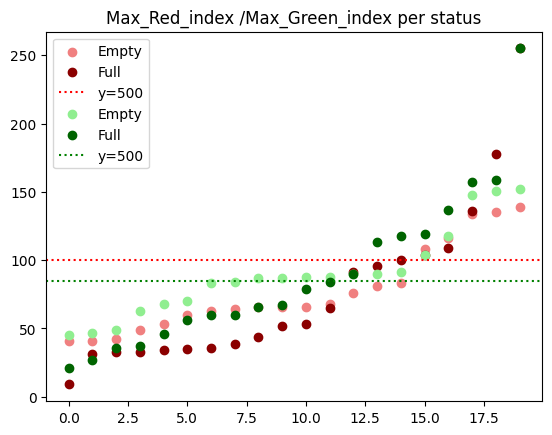

In [ ]:
max_red_empty = image_empty["Max_Red_Index"].astype(float)
max_red_full = image_full["Max_Red_Index"].astype(float)
max_green_empty = image_empty["Max_Green_Index"].astype(float)
max_green_full = image_full["Max_Green_Index"].astype(float)
plt.scatter(n.arange(len(max_red_empty)), sorted(max_red_empty), label="Empty", color='lightcoral')
plt.scatter(n.arange(len(max_red_full)), sorted(max_red_full), label="Full", color='darkred')
plt.axhline(y=100, color='red', linestyle=':', label='y=100')
plt.scatter(n.arange(len(max_green_empty)), sorted(max_green_empty), label="Empty", color='lightgreen')
plt.scatter(n.arange(len(max_green_full)), sorted(max_green_full), label="Full", color='darkgreen')
plt.axhline(y=85, color='green', linestyle=':', label='y=85')
plt.title("Max_Red_index /Max_Green_index per status")
plt.legend()
plt.show()

### Sum_rgb

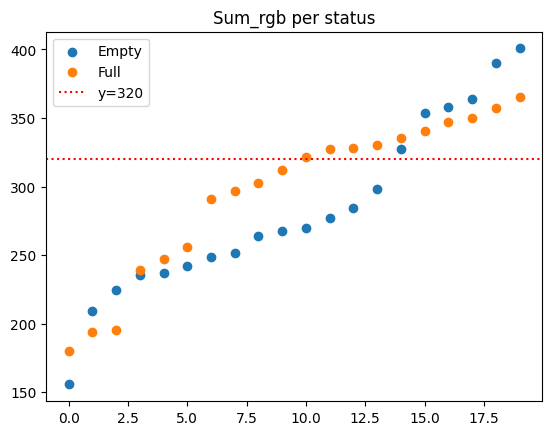

In [332]:
# Conversion des colonnes "Edges" en float pour le tri et le tracé
sum_rgb_empty = image_empty["sum_rgb"].astype(float)
sum_rgb_full = image_full["sum_rgb"].astype(float)

plt.scatter(n.arange(len(sum_rgb_empty)), sorted(sum_rgb_empty), label="Empty")
plt.scatter(n.arange(len(sum_rgb_full)), sorted(sum_rgb_full), label="Full")
plt.axhline(y=320, color='red', linestyle=':', label='y=320')
plt.title("Sum_rgb per status")
plt.legend()
plt.show()

# Conditional Model

In [333]:

# Exemple de structure de règle : 

rules = [{"feature": "Size", "operator": ">", "threshold": 500, "score": 0.26},
         {"feature": "Avg_R", "operator": "<", "threshold": 105, "score": 0.24/2},
         {"feature": "Avg_G", "operator": "<", "threshold": 110, "score": 0.23/2},
         {"feature": "Edges", "operator": ">", "threshold": 130000, "score": 0.25},
         {"feature": "Max_Red_Index", "operator": "<", "threshold": 100, "score": 0.3/2}, # diviser par deux car redondant.
         {"feature": "Max_Green_Index", "operator": "<", "threshold": 85, "score": 0.27/2},
         {"feature": "sum_rgb", "operator": "<", "threshold": 320, "score": 0.2}
         ]

def apply_rule(row, rule):
    if rule["operator"] == ">":
        return row[rule["feature"]] > rule["threshold"]
    elif rule["operator"] == "<":
        return row[rule["feature"]] < rule["threshold"]
    elif rule["operator"] == ">=":
        return row[rule["feature"]] >= rule["threshold"]
    elif rule["operator"] == "<=":
        return row[rule["feature"]] <= rule["threshold"]
    elif rule["operator"] == "==":
        return row[rule["feature"]] == rule["threshold"]
    else:
        return False

def predict_status(data, rules, threshold_score=1):
    # return True == status full
    predictions = []
    for _, row in data.iterrows():
        score = 0
        for rule in rules:
            if apply_rule(row, rule):
                score += rule["score"]
        predicted_status = 1 if score >= threshold_score else 0
        predictions.append(predicted_status)
    return predictions


# Model test - classification metrics

#### Train

In [334]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


image_data["Predicted_Status"] = predict_status(image_data, rules, threshold_score=0.2)

y_true = image_data["Status"]
y_pred = image_data["Predicted_Status"]

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("Matrice de confusion:", confusion_matrix(y_true, y_pred))
print("Rapport de classification:", classification_report(y_true, y_pred))


Accuracy: 0.45
Precision: 0.46875
Recall: 0.75
F1 Score: 0.5769230769230769
Matrice de confusion: [[ 3 17]
 [ 5 15]]
Rapport de classification:               precision    recall  f1-score   support

         0.0       0.38      0.15      0.21        20
         1.0       0.47      0.75      0.58        20

    accuracy                           0.45        40
   macro avg       0.42      0.45      0.40        40
weighted avg       0.42      0.45      0.40        40



#### Test

In [335]:
# Exctracting test datas
import settings as s
def get_image_from_db(db_path, with_label=False):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    query = "SELECT * FROM Image"

    if (with_label):
        query="SELECT * FROM Image WHERE File_path LIKE 'test/%' "
    cursor.execute(query)
    rows = cursor.fetchall()
    conn.close()

    rows = n.transpose(rows)

    columns = [
        "id_image", "File_name", "File_path", "Size", "Height", "Width",
        "Date_taken", "Avg_R", "Avg_G", "Avg_B",
        "Contrast_level", "RGB_Histogram", "Luminance_Histogram", "Edges","Status"
    ]
    return dict(zip(columns, rows))

db_path = os.path.join(s.BASE_DIR, "db.sqlite3")

image_data = get_image_from_db(db_path, True)
image_data = pd.DataFrame(image_data)
image_data[["Max_Red_Index", "Max_Green_Index", "Max_Blue_Index"]] = image_data["RGB_Histogram"].apply(extract_max_indices)
image_data["sum_rgb"] = image_data[["Avg_R", "Avg_G", "Avg_B"]].astype(float).sum(axis=1)
image_data.drop(columns=["id_image", "File_name", "File_path", "Date_taken", "RGB_Histogram", "Luminance_Histogram", "Height", "Width"], inplace=True)
image_data = image_data.astype(float)

In [336]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


image_data["Predicted_Status"] = predict_status(image_data, rules, threshold_score=0.2)

y_true = image_data["Status"]
y_pred = image_data["Predicted_Status"]

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("Matrice de confusion:", confusion_matrix(y_true, y_pred))
print("Rapport de classification:", classification_report(y_true, y_pred))


Accuracy: 0.53
Precision: 0.5135135135135135
Recall: 0.7755102040816326
F1 Score: 0.6178861788617886
Matrice de confusion: [[15 36]
 [11 38]]
Rapport de classification:               precision    recall  f1-score   support

         0.0       0.58      0.29      0.39        51
         1.0       0.51      0.78      0.62        49

    accuracy                           0.53       100
   macro avg       0.55      0.53      0.50       100
weighted avg       0.55      0.53      0.50       100

